# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Load

In [2]:
df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQBN8DPW2rdiRrY34eEM53HAzakNGSRrw4ogI-j8HyCUrbqTB_z4CeIn2IvjLF-w_6sOe5pIlypJGAA/pub?output=csv")

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Data

##  1. Question

Do smokers have higher insurance charges than non-smokers?

### Hypothesis

Null Hypothesis - There is no difference between the charges for smokers v.s non-smokers.

Alternate Hypothesis - There is a significant difference between the charges for smokers v.s non-smokers.

### 2-Sample T-test

#### Outliers

In [4]:
# how many in each group?
df["smoker"].value_counts()


no     1064
yes     274
Name: smoker, dtype: int64

In [5]:
# Filtering df out for smokers and non-smokers
smoker = df.loc[df["smoker"]== "yes"].copy()
non_smoker = df.loc[df["smoker"]== "no"].copy()

In [6]:
charges_smoker = smoker["charges"]
charges_non_smoker = non_smoker["charges"]

In [7]:
#Checking and removing outliers
zscores_cs = stats.zscore(charges_smoker)
outliers_cs = abs(zscores_cs)>3
np.sum(outliers_cs)


0

- No outliers

In [8]:
zscores_cns = stats.zscore(charges_non_smoker)
outliers_cns = abs(zscores_cns)>3
np.sum(outliers_cns)

24

In [9]:
# Removing outliers for charges_non_smoker
charges_non_smoker = charges_non_smoker[(np.abs(stats.zscore(charges_non_smoker)) < 3)]

#### Normality

In [10]:
# test the strength group for normality
result_cs = stats.normaltest(charges_smoker)
result_cs

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

In [11]:
# test the strength group for normality
result_cns = stats.normaltest(charges_non_smoker)
result_cns

NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)

- The p-value is below .05 which means the data is not normally distributed. But the sample is bigger than 15 each, thus we can move on to the next step.

#### Equal Variance

In [12]:
# Test for equal variance
result = stats.levene(charges_smoker, charges_non_smoker)
result

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)

- There is no equal variance. Will include equal_var = False

### Perform and evaluate the t-test

In [13]:
# Independent t-test with equal_var set to False
result = stats.ttest_ind(charges_smoker, charges_non_smoker, equal_var = False)
result

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)

#### Final Hypothesis

- The p-value is below .05 so I reject the null hypothesis and accept the alternate hypothesis. There is a significant difference in charges between smokers and non-smokers.

### Visualization

In [14]:
sample = df.sample(n=50,random_state=42)
charge_smoker = sample.loc[ sample["smoker"]=="yes","charges"]
charge_non_smoker = sample.loc[ sample["smoker"]=="no","charges"]
## Getting means for charges for smokers vs non-smokers
print(f"For smokers (n={len(smoker)}): Mean={np.mean(charge_smoker):.2f}")
print(f"For non-smokers (n={len(non_smoker)}): Mean={np.mean(charge_non_smoker):.2f}")

For smokers (n=274): Mean=35439.40
For non-smokers (n=1064): Mean=7309.48


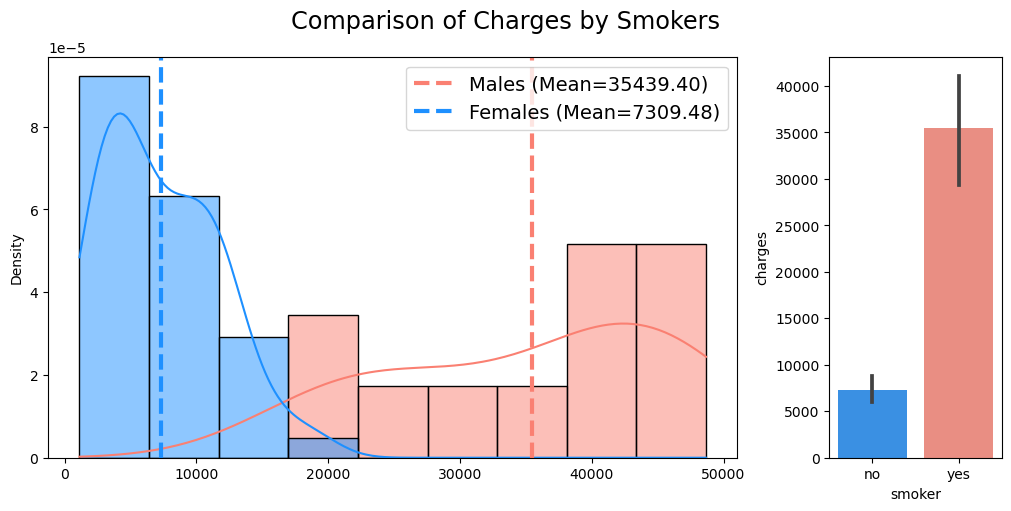

In [15]:
smoker_palette={'no':'dodgerblue', "yes":'salmon'}
## Visualizing Sample means
fig, (ax,ax_bar) = plt.subplots(figsize= (10,5), ncols=2, 
                                constrained_layout=True,
                                gridspec_kw={'width_ratios':[0.8,0.2]})


# Histogram
ax = sns.histplot(data=sample, x="charges",fill=True,hue="smoker",kde=True,
                  stat='density',common_norm=False,ax=ax,
                  palette=smoker_palette)

ax.axvline(np.mean(charge_smoker), ls='--',lw=3, 
           label=f"Males (Mean={np.mean(charge_smoker):.2f})",color=smoker_palette['yes'])

ax.axvline(np.mean(charge_non_smoker), ls='--', lw=3, 
           label=f"Females (Mean={np.mean(charge_non_smoker):.2f})",color=smoker_palette['no'])

ax.legend(prop={"size":14}, loc='upper right')#bbox_to_anchor=[1,1])
## Barplot
ax.set(xlabel = None)
sns.barplot(data=sample, x="smoker",y="charges",ax = ax_bar,palette=smoker_palette)
fig.suptitle('Comparison of Charges by Smokers',fontsize='xx-large');

## 2. Question

 Are men more likely to smoke than women?

### Hypothesis

Null Hypothesis - There is no difference between gender when finding out who is more likely to smoke.

Alternate Hypothesis - There is a significant difference between gender when finding out who is more likely to smoke.

### Chi-Squared

In [16]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


#### Testing

In [17]:
# Run the Test and Save the Output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result #this labels the results

In [18]:
# What was our p-value?
print(p)
p<.05

0.006548143503580696


True

#### Final Hypothesis

- Since our p < .05, we reject the null hypothesis that there is no relationship between a passenger's Sex and if they Smoke.

- This means that we accept the alternate hypothesis and conclude that there is a relationship between a passenger's sex and likeliehood of smoking.

#### Visualization

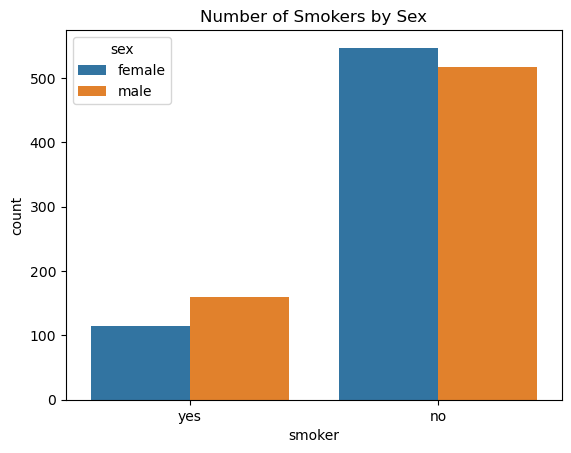

In [19]:
#Getting a view of the groups
ax = sns.countplot(data = df, x='smoker',hue='sex',)
ax.set_title("Number of Smokers by Sex");

## 3. Question

 Do different regions have different charges, on average?

### Hypothesis

Null Hypothesis - There is no difference between the average charges based on different regions.

Alternate Hypothesis - There is a significant difference between the average charges based on different regions.

### ANOVA

In [20]:
# how many in each group?
df["region"].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

#### Seperating Groups

In [21]:
## Create groups dictionary. There are only 3 groups, but this is even more helpful when there are many groups
groups = {}
## Loop through all unique categories
for i in df["region"].unique():
    ## Get series for group and rename
    data = df.loc[df["region"]==i,"charges"].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()



dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

#### Normality

In [22]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df


,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [23]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


#### Equal Variance

In [24]:
# with the * operator 
stats.levene(*groups.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

- We have not met equal variance with the Levene testing,  moving on to the Kruskal-Wallis test 

#### Kruskal-Wallis test

In [25]:
results = stats.kruskal(*groups.values())
results

KruskalResult(statistic=4.734181215658743, pvalue=0.19232908072121002)

- The test was a success with Kruskal-Wallis (median)

#### Tukey's Pairwise Multiple Comparisons Test

In [26]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
## saving the values as charges and the labels to the region
values = df['charges']
labels = df['region']



In [27]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


#### Final Hypothesis

- The Tukey multiple comparison test shows us that only southeast and southwest have a significant difference in charges. Therefore, we accept the Null Hypothesis.

#### Visualization

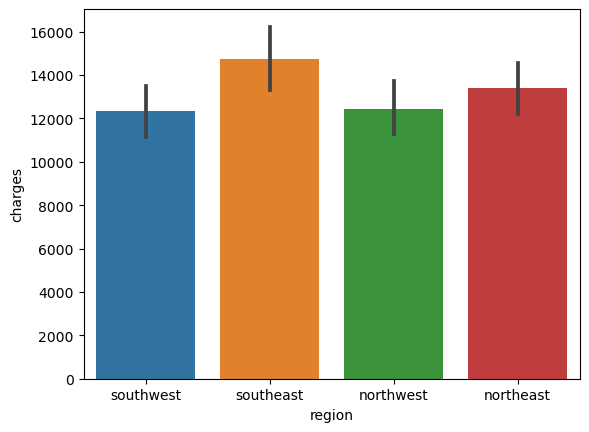

In [28]:
sns.barplot(data=df, y="charges" ,x="region");